In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

In [3]:
sys.path.append(os.path.abspath("../src/text_detector_model/training"))
sys.path.append(os.path.abspath("../src"))

In [4]:
from torchvision.transforms import v2 as T
from pathlib import Path
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import tv_tensors
import mlflow

In [5]:
from dataset import DocumentDataset
from train import train_model
from model import get_faster_rcnn_model
from utils import plot

In [8]:
data_version = "20250410185834"
document_id = 19
batch_size = 16
num_epochs = 10
device = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment(f"text_detector_model_{document_id}")

# Define transformations for input images
transform = T.Compose([
    T.ToDtype(torch.float, scale=True),
    T.Resize((800, 600)),
    T.ToPureTensor()
])

# Load data
documents_dir = Path(f"/Users/volpea/Documents/projects/document-generator-job/data/sampling/document_{document_id}/{data_version}/")

In [9]:
train_dataset = DocumentDataset(images_dir=documents_dir / "train", annotation_file=documents_dir / "train_labels.json", transform=transform)
test_val_dataset = DocumentDataset(images_dir=documents_dir / "test", annotation_file=documents_dir / "test_labels.json", transform=transform)

# Split into val/test
val_size = int(0.5 * len(test_val_dataset))
test_size = len(test_val_dataset) - val_size

val_dataset, test_dataset = torch.utils.data.random_split(
    test_val_dataset, [val_size, test_size]
)

def collate_fn(batch):
    return tuple(zip(*batch))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [10]:
train_dataset[1][0].shape

torch.Size([3, 800, 600])

In [11]:
train_dataset[1][1]

{'image_id': 1,
 'boxes': tensor([[ 82, 351, 277, 370],
         [358, 215, 515, 235],
         [309, 345, 325, 364],
         [503, 350, 533, 370],
         [132, 207, 254, 238],
         [142, 240, 293, 261],
         [383, 241, 548, 262],
         [368, 351, 384, 372],
         [369, 268, 535, 291],
         [126, 265, 291, 279]]),
 'labels': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}

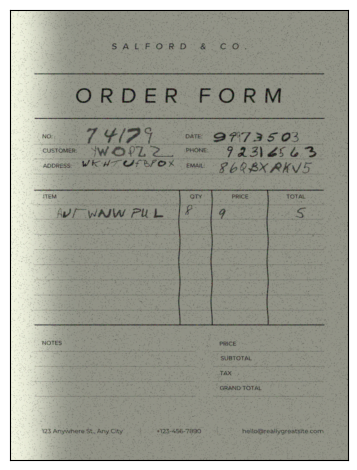

In [12]:
plot([train_dataset[1][0]])

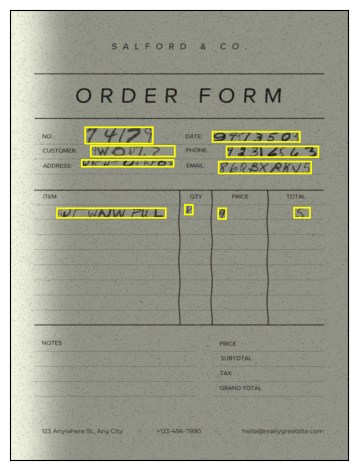

In [13]:
plot([(train_dataset[1][0], train_dataset[1][1])])

In [14]:
# Initialize model
model = get_faster_rcnn_model(len(train_dataset.classes) + 1)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [15]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(
#    optimizer,
#    step_size=3,
#    gamma=0.1
#)

In [16]:
with mlflow.start_run():
    params = {
        "num_epochs": num_epochs,
        "optimizer": optimizer.__class__.__name__,
        "batch_size": batch_size,
        "data_version": data_version
    }
    mlflow.log_params(params)

    model = train_model(model=model, 
                        train_data_loader=train_loader, 
                        val_data_loader=val_loader, 
                        optimizer=optimizer, 
                        device="cpu", 
                        num_epochs=num_epochs)

Epoch 1/10


  4%|▍         | 2/50 [01:22<33:02, 41.30s/it]


🏃 View run omniscient-tern-271 at: http://localhost:5000/#/experiments/979727546202698458/runs/72bf189bd1b544b385710f5831e4dba9
🧪 View experiment at: http://localhost:5000/#/experiments/979727546202698458


KeyboardInterrupt: 

In [ ]:
from evaluation import evaluate_model

In [ ]:
[false_negatives_df, positives_df], [precision, recall] = evaluate_model(model, test_loader, device, prediction_threshold=0.5, iou_thresold=0.90)

Evaluating model


100%|██████████| 7/7 [01:13<00:00, 10.54s/it]


In [52]:
precision, recall

(0.2919191919191919, 0.9665551839464883)

In [ ]:
image = test_dataset[0][0]
val_dataset[0][1]

{'image_id': 120,
 'boxes': tensor([[ 51, 347, 293, 368],
         [346, 209, 542, 237],
         [306, 344, 326, 364],
         [485, 349, 542, 366],
         [154, 207, 258, 238],
         [142, 242, 264, 259],
         [359, 244, 540, 263],
         [392, 356, 414, 370],
         [345, 268, 554, 290],
         [158, 273, 287, 287]]),
 'labels': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}

In [57]:
def process_document(model, image, transform, confidence_threshold=0.7):
    """
    Process a new document using the trained model
    
    Args:
        model: Trained Faster R-CNN model
        image: Input image to process
        confidence_threshold: Threshold for confidence scores
        
    Returns:
        Dictionary mapping field types to extracted text
    """
    image = tv_tensors.Image(image)

    image = transform(image)
    
    # Set model to evaluation mode
    model.eval()
    
    # Get predictions
    with torch.no_grad():
        prediction = model([image])[0]

    # Filter by confidence threshold
    mask = prediction["scores"] >= confidence_threshold
    prediction["boxes"] = prediction["boxes"][mask]
    prediction["labels"] = prediction["labels"][mask]
    prediction["scores"] = prediction["scores"][mask]
    
    return image, prediction

In [58]:
image, prediction = process_document(model, image, transform, confidence_threshold=0.8)

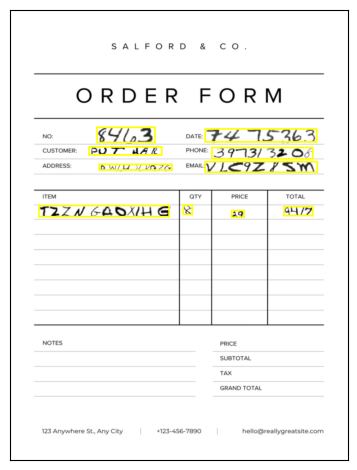

In [59]:
plot([(image, prediction)])

### Evaluate Test images

In [60]:
img = Image.open(documents_dir / "test" / "sample_139.png")

In [65]:
image, prediction = process_document(model, img, transform, confidence_threshold=0.8)

In [66]:
prediction

{'boxes': tensor([[ 47.6740, 347.8409, 290.2631, 369.8847],
         [210.0055, 210.8775, 280.5529, 227.6317],
         [460.9354, 347.9407, 504.7660, 365.4350],
         [363.9008, 270.0440, 532.3296, 286.2474],
         [116.0097, 241.3969, 295.7029, 261.6487],
         [367.4509, 347.8116, 401.4025, 371.1878],
         [354.1005, 241.1681, 550.8809, 262.3768],
         [408.6808, 217.4669, 509.5317, 233.3438],
         [105.1695, 271.3765, 204.8129, 282.4103],
         [ 49.9404, 345.7902, 287.8878, 357.5862],
         [323.5815, 344.9842, 348.1772, 359.9666]]),
 'labels': tensor([ 1,  5,  4,  9,  6,  8,  7,  2, 10,  1,  3]),
 'scores': tensor([0.9973, 0.9966, 0.9915, 0.9913, 0.9904, 0.9897, 0.9892, 0.9887, 0.9296,
         0.9091, 0.8906])}

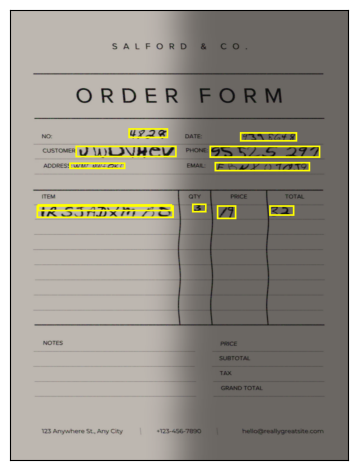

In [67]:
plot([(image, prediction)])

In [68]:
train_dataset.classes

{'Item 1': 1,
 'Date': 2,
 'Quantity 1': 3,
 'Total 1': 4,
 'Number': 5,
 'Customer': 6,
 'Phone': 7,
 'Price 1': 8,
 'Email': 9,
 'Address': 10}

## Real Image

In [90]:
import cv2
from utils import align_to_template

ImportError: cannot import name 'align_to_template' from 'utils' (/Users/volpea/Documents/projects/document-generator-text-extractor/src/utils.py)

In [79]:
image = cv2.imread("/Users/volpea/Documents/projects/document-generator-job/data/test/example_form_real_2.jpg")
template = cv2.imread("/Users/volpea/Documents/projects/document-generator-text-extractor/data/templates/example_form_template.webp")

In [80]:
registered_image = align_to_template(image, template)
registered_image = Image.fromarray(cv2.cvtColor(registered_image, cv2.COLOR_BGR2RGB))

In [81]:
image, prediction = process_document(model, registered_image, transform, confidence_threshold=0.7)

In [82]:
prediction

{'boxes': tensor([[355.7903, 221.0190, 491.4846, 235.8117],
         [354.5213, 272.3502, 547.6696, 287.8127],
         [373.1349, 350.5688, 409.3269, 364.8647],
         [114.9685, 274.1729, 232.8092, 287.6570],
         [ 56.5054, 353.5197, 168.1331, 364.8403],
         [126.9613, 246.0502, 213.2742, 258.6828],
         [ 97.3925, 217.9218, 136.6445, 232.6635],
         [472.7136, 353.9577, 517.4438, 367.0124]]),
 'labels': tensor([ 2,  9,  8, 10,  1,  6,  5,  4]),
 'scores': tensor([0.9925, 0.9893, 0.9887, 0.9872, 0.9830, 0.9736, 0.9702, 0.9097])}

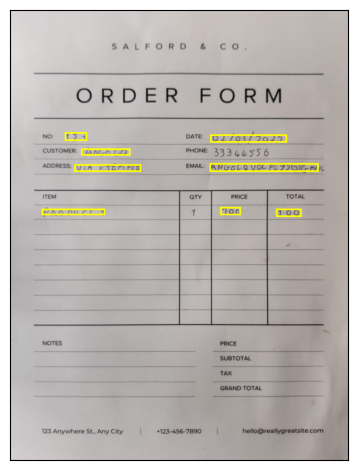

In [83]:
plot([(image, prediction)])